In [4]:
import os
import re
import pandas as pd
import fitz  # PyMuPDF
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Initialize NLP model
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Paths

# Base directory is one level up from Notebooks/
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Paths relative to base
RESUME_DIR = os.path.join(BASE_DIR, "Resumes", "data")
JD_DIR = os.path.join(BASE_DIR, "Resumes", "jobs")
OUTPUT_DIR = os.path.join(BASE_DIR, "Resumes", "output")

# Create output folder if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

[nltk_data] Downloading package stopwords to C:\Users\M4
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def extract_text_from_pdf(file_path):
    text = ""
    with fitz.open(file_path) as doc:
        for page in doc:
            text += page.get_text()
    return text

def clean_text(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return " ".join([t for t in tokens if t not in stop_words and len(t) > 2])

def extract_info(text):
    doc = nlp(text)
    name = next((ent.text for ent in doc.ents if ent.label_ == "PERSON"), None)
    emails = re.findall(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}", text)
    phones = re.findall(r"\+?\d[\d\-\(\) ]{8,}\d", text)
    skills = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN'] and not token.is_stop]

    education_keywords = ['bsc', 'msc', 'mba', 'bachelors', 'masters', 'matric', 'inter', 'mcs', 'bcs']
    education = [w for w in text.lower().split() if w in education_keywords]
    
    experience_matches = re.findall(r'\b(?:[0-9]+ ?years?|experience|worked at|company)\b.*', text, re.IGNORECASE)
    locations = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    
    return {
        'name': name,
        'email': emails[0] if emails else None,
        'phone': phones[0] if phones else None,
        'skills': list(set(skills)),
        'education': list(set(education)),
        'experience': experience_matches[:2],  # sample lines
        'location': list(set(locations))
    }

def calculate_match_score(resume_text, jd_text):
    vect = CountVectorizer().fit_transform([resume_text, jd_text])
    return round(cosine_similarity(vect[0], vect[1])[0][0] * 100, 2)


In [6]:
job_descriptions = {}
for filename in os.listdir(JD_DIR):
    if filename.endswith(".txt"):
        category = filename.replace(".txt", "").upper()
        with open(os.path.join(JD_DIR, filename), "r", encoding="utf-8") as f:
            job_descriptions[category] = clean_text(f.read())


In [7]:
results = []

for category in tqdm(os.listdir(RESUME_DIR)):
    cat_path = os.path.join(RESUME_DIR, category)
    if not os.path.isdir(cat_path): continue
    jd_clean = job_descriptions.get(category.upper(), "")
    
    for file in os.listdir(cat_path):
        if not file.lower().endswith(".pdf"):
            continue
        full_path = os.path.join(cat_path, file)
        try:
            raw_text = extract_text_from_pdf(full_path)
            clean_resume = clean_text(raw_text)
            data = extract_info(raw_text)
            data.update({
                'category': category,
                'file': file,
                'match_score': calculate_match_score(clean_resume, jd_clean)
            })
            results.append(data)
        except Exception as e:
            print(f"❌ Failed to process {file}: {e}")


100%|██████████| 24/24 [06:42<00:00, 16.76s/it]


In [8]:
df = pd.DataFrame(results)
df.to_csv(os.path.join(OUTPUT_DIR, "resumes_all.csv"), index=False)

top3_df = df.sort_values(by="match_score", ascending=False).groupby("category").head(3)
top3_df.to_csv(os.path.join(OUTPUT_DIR, "resumes_top3_per_category.csv"), index=False)

df.head()


,name,email,phone,skills,education,experience,location,category,file,match_score
0,Ledger,None,None,"[Associate, responsibility, Office, ERP, Instr...",[bachelors],"[Experience, Company Name July 2011 to Novembe...","[Accountant \nCity, Limestone, Omaha]",ACCOUNTANT,10554236.pdf,30.86
1,Microsoft Word\nEducation,None,None,"[SDI, audits, accounting, Adobe, Experience, A...",[],"[Experience, Company Name ï¼​ City , State]","[PO, North Carolina, Payables, NC]",ACCOUNTANT,10674770.pdf,35.71
2,Attributes Self,None,2 864-472-7092,"[workflow, business, Intermediate, Experience,...",[],"[Experience, Company Name ï¼​ City , State]","[Truth, Processed]",ACCOUNTANT,11163645.pdf,15.02
3,MSREF,None,None,"[Associate, Goizueta, accounting, Experience, ...",[],"[Experience, Company Name June 2011 to Current...","[U.S., MD, Georgia, United States, Fulton County]",ACCOUNTANT,11759079.pdf,17.98
4,Accountant Mar 2006,None,2001 - 2002,"[discussions, TEMPLE, APS, National, audits, a...",[],[experience in full life cycle of general ledg...,"[Seoul, Prepare, Tokyo, New York State, Name C...",ACCOUNTANT,12065211.pdf,28.58


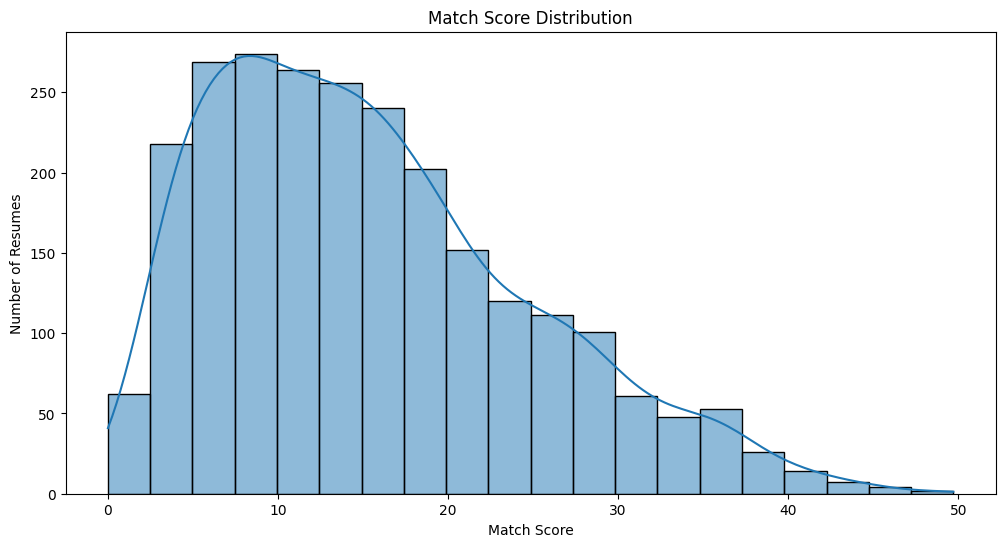

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(df['match_score'], bins=20, kde=True)
plt.title("Match Score Distribution")
plt.xlabel("Match Score")
plt.ylabel("Number of Resumes")
plt.show()
